In [1]:
import numpy as np
import random

# Set a global random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [2]:
"""Catch22 Classifier.

Pipeline classifier using the Catch22 transformer and an estimator.
"""

__maintainer__ = []
__all__ = ["Catch22Classifier"]

import numpy as np
from sklearn.ensemble import RandomForestClassifier

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
from aeon.transformations.collection.feature_based import Catch22


class Catch22Classifier(BaseClassifier):
    """
    Canonical Time-series Characteristics (catch22) classifier.

    This classifier simply transforms the input data using the Catch22 [1]_
    transformer and builds a provided estimator using the transformed data.

    Parameters
    ----------
    features : int/str or List of int/str, default="all"
        The Catch22 features to extract by feature index, feature name as a str or as a
        list of names or indices for multiple features. If "all", all features are
        extracted. Valid features are as follows:
            ["DN_HistogramMode_5", "DN_HistogramMode_10",
            "SB_BinaryStats_diff_longstretch0", "DN_OutlierInclude_p_001_mdrmd",
            "DN_OutlierInclude_n_001_mdrmd", "CO_f1ecac", "CO_FirstMin_ac",
            "SP_Summaries_welch_rect_area_5_1", "SP_Summaries_welch_rect_centroid",
            "FC_LocalSimple_mean3_stderr", "CO_trev_1_num", "CO_HistogramAMI_even_2_5",
            "IN_AutoMutualInfoStats_40_gaussian_fmmi", "MD_hrv_classic_pnn40",
            "SB_BinaryStats_mean_longstretch1", "SB_MotifThree_quantile_hh",
            "FC_LocalSimple_mean1_tauresrat", "CO_Embed2_Dist_tau_d_expfit_meandiff",
            "SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1",
            "SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1",
            "SB_TransitionMatrix_3ac_sumdiagcov", "PD_PeriodicityWang_th0_01"]
    catch24 : bool, default=True
        Extract the mean and standard deviation as well as the 22 Catch22 features if
        true. If a List of specific features to extract is provided, "Mean" and/or
        "StandardDeviation" must be added to the List to extract these features.
    outlier_norm : bool, optional, default=False
        Normalise each series during the two outlier Catch22 features, which can take a
        while to process for large values.
    replace_nans : bool, default=True
        Replace NaN or inf values from the Catch22 transform with 0.
    use_pycatch22 : bool, default=False
        Wraps the C based pycatch22 implementation for aeon.
        (https://github.com/DynamicsAndNeuralSystems/pycatch22). This requires the
        ``pycatch22`` package to be installed if True.
    estimator : sklearn classifier, default=None
        An sklearn estimator to be built using the transformed data.
        Defaults to sklearn RandomForestClassifier(n_estimators=200).
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    parallel_backend : str, ParallelBackendBase instance or None, default=None
        Specify the parallelisation backend implementation in joblib for Catch22,
        if None a 'prefer' value of "threads" is used by default.
        Valid options are "loky", "multiprocessing", "threading" or a custom backend.
        See the joblib Parallel documentation for more details.

    Attributes
    ----------
    n_classes_ : int
        Number of classes. Extracted from the data.
    classes_ : ndarray of shape (n_classes_)
        Holds the label for each class.
    estimator_ : sklearn classifier
        The fitted estimator.

    See Also
    --------
    Catch22
        Catch22 transformer in aeon/transformations/collection.

    Notes
    -----
    Authors `catch22ForestClassifier <https://github.com/chlubba/sktime-catch22>`_.

    For the Java version, see `tsml <https://github.com/uea-machine-learning/tsml/blob
    /master/src/main/java/tsml/classifiers/hybrids/Catch22Classifier.java>`_.

    References
    ----------
    .. [1] Lubba, Carl H., et al. "catch22: Canonical time-series characteristics."
        Data Mining and Knowledge Discovery 33.6 (2019): 1821-1852.
        https://link.springer.com/article/10.1007/s10618-019-00647-x

    Examples
    --------
    >>> from aeon.classification.feature_based import Catch22Classifier
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from aeon.testing.data_generation import make_example_3d_numpy
    >>> X, y = make_example_3d_numpy(n_cases=10, n_channels=1, n_timepoints=12,
    ...                              return_y=True, random_state=0)
    >>> clf = Catch22Classifier(
    ...     estimator=RandomForestClassifier(n_estimators=5),
    ...     outlier_norm=True,
    ...     random_state=0,
    ... )
    >>> clf.fit(X, y)
    Catch22Classifier(...)
    >>> clf.predict(X)
    array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])
    """

    _tags = {
        "X_inner_type": ["np-list", "numpy3D"],
        "capability:multivariate": True,
        "capability:unequal_length": True,
        "capability:multithreading": True,
        "algorithm_type": "feature",
    }

    def __init__(
        self,
        features="all",
        catch24=True,
        outlier_norm=False,
        replace_nans=True,
        use_pycatch22=False,
        estimator=None,
        random_state=None,
        n_jobs=1,
        parallel_backend=None,
    ):
        self.features = features
        self.catch24 = catch24
        self.outlier_norm = outlier_norm
        self.replace_nans = replace_nans
        self.use_pycatch22 = use_pycatch22
        self.estimator = estimator
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.parallel_backend = parallel_backend

        super().__init__()

    def _fit(self, X, y):
        """Fit Catch22Classifier to training data.

        Parameters
        ----------
        X : 3D np.ndarray (any number of channels, equal length series)
                of shape (n_cases, n_channels, n_timepoints)
            or list of numpy arrays (any number of channels, unequal length series)
                of shape [n_cases], 2D np.array (n_channels, n_timepoints_i), where
                n_timepoints_i is length of series i
        y : 1D np.array, of shape [n_cases] - class labels for fitting
            indices correspond to instance indices in X

        Returns
        -------
        self :
            Reference to self.
        """
        self._transformer = Catch22(
            features=self.features,
            catch24=self.catch24,
            outlier_norm=self.outlier_norm,
            replace_nans=self.replace_nans,
            use_pycatch22=self.use_pycatch22,
            n_jobs=self._n_jobs,
            parallel_backend=self.parallel_backend,
        )

        self.estimator_ = _clone_estimator(
            (
                RandomForestClassifier(n_estimators=200)
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        m = getattr(self.estimator_, "n_jobs", None)
        if m is not None:
            self.estimator_.n_jobs = self._n_jobs

        X_t = self._transformer.fit_transform(X, y)
        self.estimator_.fit(X_t, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray (any number of channels, equal length series)
                of shape (n_cases, n_channels, n_timepoints)
            or list of numpy arrays (any number of channels, unequal length series)
                of shape [n_cases], 2D np.array (n_channels, n_timepoints_i), where
                n_timepoints_i is length of series i

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        return self.estimator_.predict(self._transformer.transform(X))

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray (any number of channels, equal length series)
                of shape (n_cases, n_channels, n_timepoints)
            or list of numpy arrays (any number of channels, unequal length series)
                of shape [n_cases], 2D np.array (n_channels, n_timepoints_i), where
                n_timepoints_i is length of series i

        Returns
        -------
        y : array-like, shape = [n_cases, n_classes_]
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self.estimator_, "predict_proba", None)
        if callable(m):
            return self.estimator_.predict_proba(self._transformer.transform(X))
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self.estimator_.predict(self._transformer.transform(X))
            for i in range(0, X.shape[0]):
                dists[i, self._class_dictionary[preds[i]]] = 1
            return dists

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            Catch22Classifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        if parameter_set == "results_comparison":
            return {
                "estimator": RandomForestClassifier(n_estimators=10),
                "outlier_norm": True,
            }
        else:
            return {
                "estimator": RandomForestClassifier(n_estimators=2),
                "features": (
                    "Mean",
                    "DN_HistogramMode_5",
                    "SB_BinaryStats_mean_longstretch1",
                ),
            }

In [3]:
import os
import numpy as np
import librosa

def load_data_from_directory(directory, sample_length=16000, n_channels=1):
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}  # Create a label to index mapping

    total_files = 0  # Initialize a counter for total files

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            file_count = 0  # Counter for files in the current class directory
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_count += 1  # Increment file count for the current class
                    file_path = os.path.join(class_dir, file_name)
                    # Load audio
                    signal, sr = librosa.load(file_path, sr=16000)
                    # Ensure length is 1 second (16000 samples)
                    if len(signal) != sample_length:
                        # Pad or truncate to sample_length
                        if len(signal) < sample_length:
                            signal = np.pad(signal, (0, sample_length - len(signal)))
                        else:
                            signal = signal[:sample_length]
                    # Reshape signal to match (n_channels, n_timepoints)
                    X.append(signal.reshape(n_channels, -1))  # Reshape to (1, sample_length)
                    y.append(label_map[label])  # Use the index of the label

            total_files += file_count  # Add the current class file count to the total
            print(f"Total number of files in folder '{label}': {file_count}")

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(y.shape)
    print(y)
    print(f"Overall total number of files in the dataset: {total_files}")

    return X, y, labels

# Load and preprocess data
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_from_directory(directory)


Total number of files in folder 'down': 2359
Total number of files in folder 'go': 2372
Total number of files in folder 'left': 2353
Total number of files in folder 'no': 2375
Total number of files in folder 'off': 2357
Total number of files in folder 'on': 2367
Total number of files in folder 'right': 2367
Total number of files in folder 'silence': 2010
Total number of files in folder 'stop': 2380
Total number of files in folder 'unknown': 2000
Total number of files in folder 'up': 2375
Total number of files in folder 'yes': 2377
(27692, 1, 16000)
(27692,)
[ 0  0  0 ... 11 11 11]
Overall total number of files in the dataset: 27692


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:



# Split data into training and testing sets with a fixed random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)






In [6]:
# Initialize the Classifier

clf = Catch22Classifier(
    random_state=SEED
)







In [7]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

Catch22Classifier(random_state=42)

In [8]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.4814948546669074


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.48140048324983625
Recall (macro): 0.48725137963103055
F1 Score (macro): 0.47667949412491906


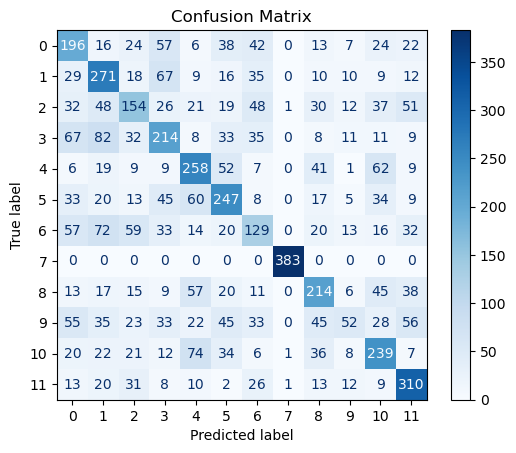

In [10]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


